**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [38]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Let's train a neural network on Fashion MNIST

In [39]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

You can also scale the inputs to mean 0 and standard deviation 1:

In [40]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

# Batch Normalization

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_12 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 300)               235500    
                                                                 
 batch_normalization_13 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 100)               30100     
                                                                 
 batch_normalization_14 (Bat  (None, 100)             

In [43]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_12/gamma:0', True),
 ('batch_normalization_12/beta:0', True),
 ('batch_normalization_12/moving_mean:0', False),
 ('batch_normalization_12/moving_variance:0', False)]

In [44]:
bn1.updates

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  """Entry point for launching an IPython kernel.


[]

In [45]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [46]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8523 - accuracy: 0.7169 - val_loss: 0.5527 - val_accuracy: 0.8180
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5706 - accuracy: 0.8040 - val_loss: 0.4746 - val_accuracy: 0.8408
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5110 - accuracy: 0.8228 - val_loss: 0.4395 - val_accuracy: 0.8510
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4777 - accuracy: 0.8341 - val_loss: 0.4213 - val_accuracy: 0.8568
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4561 - accuracy: 0.8383 - val_loss: 0.4065 - val_accuracy: 0.8606
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4408 - accuracy: 0.8452 - val_loss: 0.3923 - val_accuracy: 0.8660
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4226 - accuracy: 0.8506 - val_loss: 0.3853 - val_ac

Evaluation

In [47]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.4013 - accuracy: 0.8612 - 661ms/epoch - 2ms/step

Test accuracy: 0.8611999750137329


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [48]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [49]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [37]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 1.0511 - accuracy: 0.6689 - val_loss: 0.6769 - val_accuracy: 0.7844
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6818 - accuracy: 0.7826 - val_loss: 0.5594 - val_accuracy: 0.8132
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5930 - accuracy: 0.8058 - val_loss: 0.5052 - val_accuracy: 0.8288
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5480 - accuracy: 0.8155 - val_loss: 0.4722 - val_accuracy: 0.8380
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5171 - accuracy: 0.8247 - val_loss: 0.4494 - val_accuracy: 0.8474
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4919 - accuracy: 0.8326 - val_loss: 0.4323 - val_accuracy: 0.8532
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4766 - accuracy: 0.8367 - val_loss: 0.4195 - val_

Evaluation

In [50]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 2.4853 - accuracy: 0.0986 - 1s/epoch - 3ms/step

Test accuracy: 0.09860000014305115


## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [51]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [52]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# Faster Optimizers

## Momentum optimization

In [53]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [54]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [55]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


## RMSProp

In [56]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Adam Optimization

In [57]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Adamax Optimization

In [58]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


## Nadam Optimization

In [59]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Training

In [60]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])

In [61]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 19s 10ms/step - loss: 0.4600 - accuracy: 0.8351 - val_loss: 0.3360 - val_accuracy: 0.8714
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3522 - accuracy: 0.8714 - val_loss: 0.3276 - val_accuracy: 0.8778
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3168 - accuracy: 0.8829 - val_loss: 0.2935 - val_accuracy: 0.8904
Epoch 4/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.2887 - accuracy: 0.8942 - val_loss: 0.2936 - val_accuracy: 0.8912
Epoch 5/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.2704 - accuracy: 0.8983 - val_loss: 0.2978 - val_accuracy: 0.8918
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2541 - accuracy: 0.9053 - val_loss: 0.3057 - val_accuracy: 0.8892
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2400 - accuracy: 0.9092 - val_loss: 0.2866 - v

Evaluation

In [64]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3213 - accuracy: 0.8871 - 710ms/epoch - 2ms/step

Test accuracy: 0.8870999813079834


## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [65]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [66]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [67]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4909 - accuracy: 0.8282 - val_loss: 0.4132 - val_accuracy: 0.8550
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3824 - accuracy: 0.8632 - val_loss: 0.3869 - val_accuracy: 0.8628
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3485 - accuracy: 0.8763 - val_loss: 0.3660 - val_accuracy: 0.8694
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3276 - accuracy: 0.8832 - val_loss: 0.3558 - val_accuracy: 0.8762
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3112 - accuracy: 0.8888 - val_loss: 0.3518 - val_accuracy: 0.8770
Epoch 6/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2981 - accuracy: 0.8944 - val_loss: 0.3416 - val_accuracy: 0.8792
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2872 - accuracy: 0.8973 - val_loss: 0.3432 - val_accuracy:

Evaluation

In [68]:
test_loss, test_acc = model.evaluate(X_test_scaled,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.7569 - accuracy: 0.7364 - 609ms/epoch - 2ms/step

Test accuracy: 0.7364000082015991


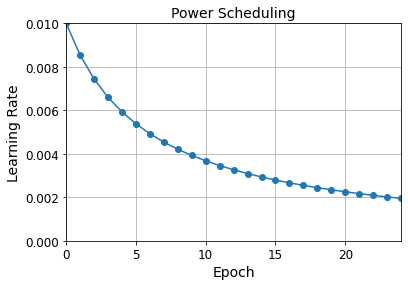

In [69]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [70]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [71]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [72]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [73]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8360 - accuracy: 0.7607 - val_loss: 0.7780 - val_accuracy: 0.7592 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7299 - accuracy: 0.7854 - val_loss: 0.9459 - val_accuracy: 0.7344 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7023 - accuracy: 0.7999 - val_loss: 0.6949 - val_accuracy: 0.8322 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5969 - accuracy: 0.8200 - val_loss: 0.6617 - val_accuracy: 0.8240 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5445 - accuracy: 0.8359 - val_loss: 0.6641 - val_accuracy: 0.8224 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5069 - accuracy: 0.8488 - val_loss: 0.5158 - val_accuracy: 0.8502 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

Evaluation

In [74]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 3.1343 - accuracy: 0.6369 - 613ms/epoch - 2ms/step

Test accuracy: 0.636900007724762


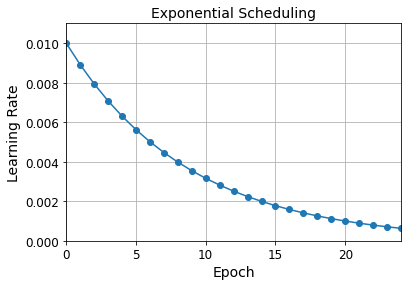

In [75]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [76]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [77]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


1719/1719 [==============================] - 15s 8ms/step - loss: 0.7929 - accuracy: 0.7680 - val_loss: 0.6123 - val_accuracy: 0.8114 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6178 - accuracy: 0.8089 - val_loss: 0.5675 - val_accuracy: 0.8272 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5729 - accuracy: 0.8217 - val_loss: 0.7032 - val_accuracy: 0.7642 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4992 - accuracy: 0.8417 - val_loss: 0.4854 - val_accuracy: 0.8494 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4656 - accuracy: 0.8523 - val_loss: 0.6864 - val_accuracy: 0.8510 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4192 - accuracy: 0.8655 - val_loss: 0.5311 - val_accuracy: 0.8724 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 14s 8ms

In [78]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

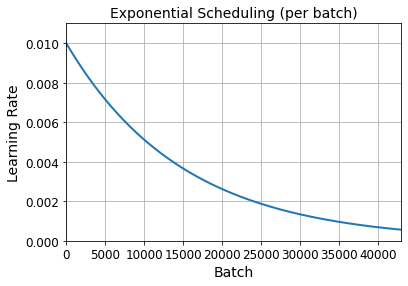

In [79]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [80]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [81]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 14s 7ms/step - loss: 0.8330 - accuracy: 0.7577 - val_loss: 1.1280 - val_accuracy: 0.6484 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8598 - accuracy: 0.7496 - val_loss: 0.8594 - val_accuracy: 0.7574 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8554 - accuracy: 0.7630 - val_loss: 1.1079 - val_accuracy: 0.6042 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8163 - accuracy: 0.7716 - val_loss: 1.1522 - val_accuracy: 0.7504 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8902 - accuracy: 0.7465 - val_loss: 0.8910 - val_accuracy: 0.7592 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5054 - accuracy: 0.8441 - val_loss: 0.6223 - val_accuracy: 0.8432 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

In [ ]:
Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

# Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
X_train_A.shape

In [ ]:
X_train_B.shape

In [ ]:
y_train_A[:30]

In [ ]:
y_train_B[:30]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

In [ ]:
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

In [ ]:
model.summary()

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

So, what's the final verdict?

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4!

In [ ]:
(100 - 96.95) / (100 - 99.25)